In [39]:
import os
import sys
import random
from tqdm import tqdm
import torch

print(torch.__version__)

0.4.1.post2


In [82]:
# consts
split_name = 'voc-1'
root_path = '/home/voyager/data/root/voc/'
train_ratio = 0.8

image_path = os.path.join(root_path, 'JPEGImages')
anno_path = os.path.join(root_path, 'Annotations')
split_path = os.path.join(root_path, 'ImageSets/Main')

# list annotation
anno_file_list = os.listdir(anno_path)
anno_list = [anno_file.split('.')[0] for anno_file in anno_file_list]

# sample
train_list = random.sample(anno_list, int(len(anno_list) * train_ratio))

val_list = []
for anno in anno_list:
    if anno not in train_list:
        val_list.append(anno)
        
# save
with open(os.path.join(split_path, '{}_{}.txt'.format(
    split_name,
    'train'
)), 'w') as train_file:
    for train_anno in train_list:
        train_file.write('{}\n'.format(train_anno))
        
with open(os.path.join(split_path, '{}_{}.txt'.format(
    split_name,
    'val'
)), 'w') as val_file:
    for val_anno in val_list:
        val_file.write('{}\n'.format(val_anno))
        

## some dirty work

In [68]:
import PIL.Image
import uuid

# convert to jpg
def convert_imgs(img_path):
    img_list = os.listdir(img_path)
    
    for filename in tqdm(img_list):
        arr = filename.split('.')

        im = PIL.Image.open(os.path.join(img_path, filename))
        
        # we have read image, remove the original one
        os.remove(os.path.join(img_path, filename))
        
        im = im.convert('RGB')
        im.save(os.path.join(img_path, '{}.jpg'.format(arr[0])))
        
# rename with uuid
def convert_names(root_path, no):
    img_path = os.path.join(root_path, 'img_{}/'.format(no))
    anno_path = os.path.join(root_path, 'anno_{}/'.format(no))
    
    img_list = os.listdir(img_path)
    anno_list = os.listdir(anno_path)
    
    table = []
    
    for anno_file in tqdm(anno_list):
        arr = anno_file.split('.')
        name = arr[0]
        
        if len(name.split('-')) > 1:
            score = int(name.split('-')[1])
        elif len(name.split('(')) > 1:
            score = name.split('(')[1]
            score = int(score.split(')')[0])
        elif len(name.split('（')) > 1:
            score = name.split('（')[1]
            score = int(score.split('）')[0])
        else:
            print(name)
            
        uid = uuid.uuid4()
        
        os.rename(
            os.path.join(img_path, '{}.jpg'.format(name)),
            os.path.join(img_path, '{}.jpg'.format(uid, score))
        )
        
        os.rename(
            os.path.join(anno_path, '{}.xml'.format(name)),
            os.path.join(anno_path, '{}.xml'.format(uid))
        )
        
        table.append({
            'uid': uid,
            'score': score
        })
        
    return table

dirty_root_path = '/home/voyager/data/root/dirty/'


In [72]:
img1_path = os.path.join(dirty_root_path, 'img_1')
convert_imgs(img1_path)

100%|██████████| 1137/1137 [00:12<00:00, 90.23it/s]


In [73]:
img2_path = os.path.join(dirty_root_path, 'img_2')
convert_imgs(img2_path)

100%|██████████| 447/447 [00:06<00:00, 70.72it/s]


In [78]:
img3_path = os.path.join(dirty_root_path, 'img_3')
convert_imgs(img3_path)

100%|██████████| 39/39 [00:00<00:00, 79.31it/s]


please remove non-jpeg files under image folders

there's a sample called 33（73), please change both jpg and xml to 33(73) by hand

In [74]:
table_1 = convert_names(dirty_root_path, 1)

100%|██████████| 1111/1111 [00:00<00:00, 19156.80it/s]


In [75]:
table_2 = convert_names(dirty_root_path, 2)

100%|██████████| 434/434 [00:00<00:00, 11176.71it/s]


In [79]:
table_3 = convert_names(dirty_root_path, 3)

100%|██████████| 39/39 [00:00<00:00, 7487.09it/s]


now, export score list

In [80]:
table = table_1.copy()
table.extend(table_2)
table.extend(table_3)

score_path = os.path.join(root_path, 'score.csv')
print(score_path)

with open(score_path, 'w') as score_csv:
    score_csv.write('id,score\n')
    
    for score in table:
        score_csv.write('{},{}\n'.format(score['uid'], score['score']))


/home/voyager/data/root/score.csv


Now copy images to JPEGImages/, annotations to Annotations/

let's try to read with voc dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


BoundingBoxesOnImage([BoundingBox(x1=423.0000, y1=158.0000, x2=503.0000, y2=334.0000, label=None), BoundingBox(x1=409.0000, y1=86.0000, x2=504.0000, y2=334.0000, label=None)], shape=(478, 616, 3))
[BoundingBox(x1=436.0000, y1=168.0000, x2=516.0000, y2=344.0000, label=None), BoundingBox(x1=422.0000, y1=96.0000, x2=517.0000, y2=344.0000, label=None)]
0.800000011920929 0.05882352963089943 [(tensor([0, 1]), tensor([[336.3684, 236.0210, 402.6089, 377.4745],
        [325.2050, 178.4143, 404.4084, 377.4884]], dtype=torch.float64))]


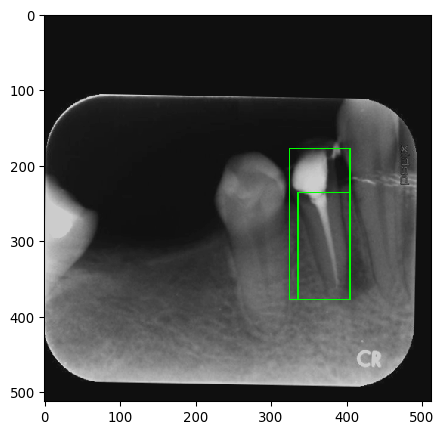

In [32]:
from dataset import voc
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as trans
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
from retinanet import transforms as aug

# consts
split_name = 'voc-1'
root_path = '/home/voyager/data/root/voc/'
image_size = 512

def show_bbs(img, anno):
    gts = anno[1].numpy()
    np_img = img.to(dtype=torch.float32).cpu().numpy()
    np_img = np.transpose(np_img, (1, 2, 0))

    bbs = []
    for gt in gts:
        bbs.append(BoundingBox(x1=gt[0], y1=gt[1], x2=gt[2], y2=gt[3]))

    bbs_on_img = BoundingBoxesOnImage(bbs, shape=np_img.shape)
    draw_img = bbs_on_img.draw_on_image(np_img, size=2)
    ia.imshow(draw_img)

train_trans = aug.Compose([
    aug.RandomCropAndPad(),
    aug.Pad(), # pad to square image
    aug.Resize(image_size, image_size),
    aug.RandomFlipLeftRight(0.5),
    aug.RandomFlipUpDown(0.5),
    aug.RandomRotate(5),
    aug.RandomTranslatePc(50, 50),
    aug.AutoLevel(min_level_rate=1, max_level_rate=1),
    aug.AutoContrast(),
    aug.RandomContrast(0.5),
    aug.Contrast(1.25),
    aug.RandomChoice([
        aug.RandomSaltPepperNoise(0.9, 0.5),
        aug.RandomSaltPepperNoise(0.95, 0.5),
        aug.RandomSaltPepperNoise(0.99, 0.5)
    ]),
    aug.ToTensor(),
    # aug.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)) # mean and std of pretrained model
])

# train set
train_set = voc.VOCDetection(
    root_path,
    image_set="voc-1_train",
    transforms=train_trans
)

train_loader = DataLoader(
    train_set,
    batch_size=1,
    shuffle=False,
    collate_fn=voc.collate
)

for i, batch in enumerate(train_loader):
    imgs, annos = batch
    
    print(torch.max(imgs).item(), torch.min(imgs).item(), annos)
    show_bbs(imgs[0], annos[0])
    
    break
    

# Scoring dataset creation

In [46]:
# helper
import collections
import pandas as pd

if sys.version_info[0] == 2:
    import xml.etree.cElementTree as ET
else:
    import xml.etree.ElementTree as ET

from dataset import voc
    
def parse_voc_xml(node):
    voc_dict = {}
    children = list(node)
    if children:
        def_dic = collections.defaultdict(list)
        for dc in map(parse_voc_xml, children):
            for ind, v in dc.items():
                def_dic[ind].append(v)
        voc_dict = {
            node.tag:
                {ind: v[0] if len(v) == 1 else v
                 for ind, v in def_dic.items()}
        }
    if node.text:
        text = node.text.strip()
        if not children:
            voc_dict[node.tag] = text
    return voc_dict

In [51]:
# expand score.csv to bbox_score.csv

root_path = '/home/voyager/data/root/'
voc_path = os.path.join(root_path, 'voc')
anno_path = os.path.join(voc_path, 'Annotations')
score_filename = 'score.csv'
result_filename = 'bbox_score.csv'

score_path = os.path.join(root_path, score_filename)
score_df = pd.read_csv(score_path)

print(score_df.head(5))

uid_list = score_df['id']
score_list = score_df['score']

with open(os.path.join(root_path, result_filename), 'w') as result_csv:
    result_csv.write('id,serial,class,score,x1,y1,x2,y2,prob\n')
    
    for uid, score in zip(uid_list, score_list):
        # read xml annotation
        xml_path = os.path.join(anno_path, '{}.xml'.format(uid))
        target = parse_voc_xml(
            ET.parse(xml_path).getroot()
        )
        anno = voc.convert_voc_2_retina(target, voc.RETINA_CLASSES)

        for i, data in enumerate(zip(anno[0], anno[1])):
            class_no, bbox = data
            
            result_csv.write('{},{},{},{},{},{},{},{},{}\n'.format(
                uid,
                i,
                class_no,
                score,
                bbox[0],
                bbox[1],
                bbox[2],
                bbox[3],
                1.0
            ))
    

                                     id  score
0  feeb05d5-1922-408d-9615-126e7bca0f9d     78
1  ff6f9ea2-d2e9-443d-b217-e77f5b5c1ab6     78
2  d5b31460-8be6-4491-a8b6-33186ab480f7     75
3  e425215c-a59c-48a6-b8c4-4db4eb08e842     75
4  684f631f-0a26-4dca-828b-518a459d4dbc    102


now, split into train and val datasets

In [58]:
# consts
split_name = 'score-1'
root_path = '/home/voyager/data/root/'
bbox_score_filename = 'bbox_score.csv'
train_ratio = 0.8
root_only = True

bbox_score_df = pd.read_csv(os.path.join(root_path, bbox_score_filename))

print('total: {}, root: {}, tooth: {}'.format(
    len(bbox_score_df),
    len(bbox_score_df[bbox_score_df['class'] == 0]),
    len(bbox_score_df[bbox_score_df['class'] == 1])
))

if root_only:
    bbox_score_df = bbox_score_df[bbox_score_df['class'] == 0]

train_score_df = bbox_score_df.sample(frac=train_ratio)
val_score_df = bbox_score_df.drop(train_score_df.index)

print('total: {}, train: {}, val: {}'.format(
    len(bbox_score_df),
    len(train_score_df),
    len(val_score_df)
))

train_score_df.to_csv(os.path.join(root_path, '{}_train.csv'.format(split_name)), index=False)
val_score_df.to_csv(os.path.join(root_path, '{}_val.csv'.format(split_name)), index=False)

total: 3783, root: 1948, tooth: 1835
total: 1948, train: 1558, val: 390
